In [1]:
#Use this cell to import all the required libraries.
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS

# Data exploration
from sklearn.preprocessing import LabelEncoder
import re

# Text Preparation
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag

from sklearn.feature_extraction.text import CountVectorizer

# Feature engineering
## BOW
from sklearn.feature_extraction.text import CountVectorizer 
## TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer
## dimensionality reduction
from sklearn.decomposition import TruncatedSVD
## Doc2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
## Topic Modeling
import gensim.corpora as corpora
from gensim import models
from gensim.models.coherencemodel import CoherenceModel
## Sentiment Analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer # Lexicon-based method_unsupervised

# Model Building & Evaluation
## Neural Network
from sklearn.neural_network import MLPClassifier
## Scale
from sklearn.preprocessing import StandardScaler
## Cross Validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
## Confusion Matrix
from sklearn.metrics import confusion_matrix

In [2]:
raw_data = pd.read_excel("Assignment_Data.xlsx")

# Data exploration

- Finding 1: This dataset is balanced. For the target variable "misinformation," misinformation accounts for 51.4%, while non-misinformation accounts for 48.6%.  


- Finding 2: "user_following" and "user_country" columns can be deleted. As for several columns that only have a few missing values, just delete the row with the missing value.
  - 66.67% of "user_following" is missing and 31.88% of users don't follow any users.
  - "user_country" only has two values ("US" and "AU"), and most of the tweets are from "US". It is helpless to identify misleading information.    
  
  
- Finding 3: According to the correlation heat map, most of the numerical data is not relevant to "misinformation." Moreover, "post_quotes" should be deleted because it is highly relevant with three features.    


- Finding 4: Misinformation tweets accounted for a higher proportion of tweets with more than 1,000 followers.    


- Finding 5: There are a large number of misinformation tweets related to the same news author.  


- Finding 6: The "related_tweet" column can be split into three columns, including "mentions," "hashtags," and "tweet_content."  


- Finding 7: "realDonaldTrump" is mentioned the most.  


- Finding 8: Most mentioned hashtags are about policy, for example "#GOPDebate," "#SOTU," "#MAGA," and "#Trump." Except for "COVID 19" is about pandemic.

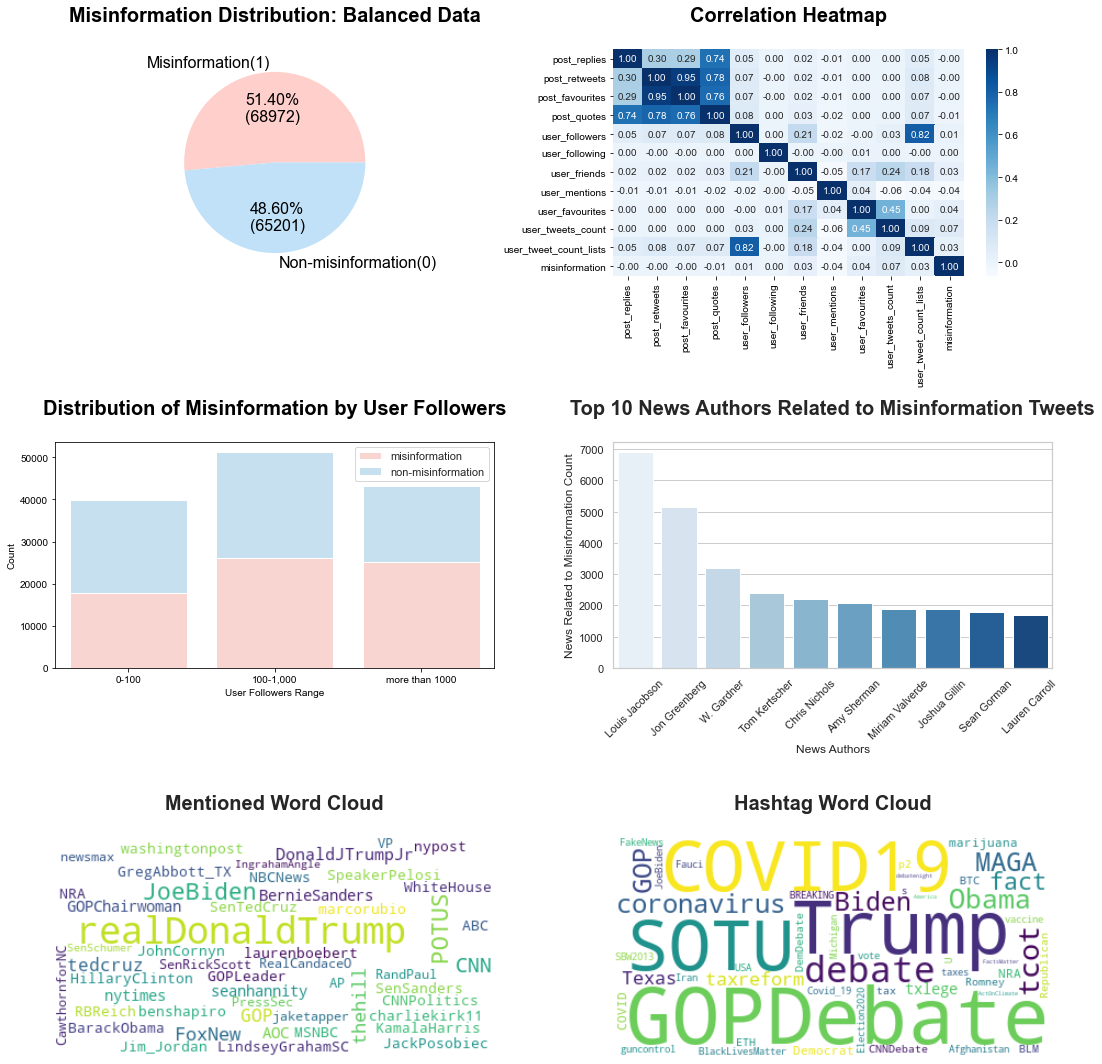

In [3]:
# ensure the data integrity
df = raw_data.copy()

"""Understand the Data"""
# 1. distribution of target variable "misinformation"
misinformation_counts = df["misinformation"].value_counts()
plt.figure(figsize=(15, 15))  # Adjust figsize as needed
plt.subplot(3, 2, 1)  # Subplot 1
colors = ["#ffcfcc", "#C0E1F7"]
plt.pie(misinformation_counts, autopct=lambda pct: "{:.2f}%\n({:d})".format(pct, int(pct/100.*sum(misinformation_counts))),
        labels=['Misinformation(1)', 'Non-misinformation(0)'], colors=colors, textprops={"fontsize": 16})
plt.title("Misinformation Distribution: Balanced Data\n", size=20, fontweight="bold")

# 2. the numbers of missing values in the dataset
df_missing_value = df.isnull().sum()
df_missing_user_following = df.value_counts("user_following")
df_missing_user_country = df.value_counts("user_country")

# 3. correlation between all numerical data
df_num = df.describe()
plt.subplot(3, 2, 2)  # Subplot 2
sns.heatmap(df.corr(), cmap="Blues", annot=True, fmt=".2f", annot_kws={"size": 10})
plt.title("Correlation Heatmap\n", size=20, fontweight="bold")

# 4. misinformation distribution of "user_followers"
bins = [0, 100, 1000, float("inf")]
labels = ["0-100", "100-1,000", "more than 1000"]
df["user_followers_range"] = pd.cut(df["user_followers"], bins=bins, labels=labels, right=False)

grouped = df.groupby(["user_followers_range", "misinformation"]).size().unstack(fill_value=0) # group by misinfomation

plt.subplot(3, 2, 3)  # Subplot 3
sns.set(style="whitegrid")
sns.barplot(data=grouped.reset_index(), x="user_followers_range", y=1, color="#ffcfcc", label="misinformation")
sns.barplot(data=grouped.reset_index(), x="user_followers_range", y=0, color="#C0E1F7", label="non-misinformation", bottom=grouped[1])
plt.xlabel("User Followers Range")
plt.ylabel("Count")
plt.title("Distribution of Misinformation by User Followers\n", size=20, fontweight="bold")
plt.legend()

# 5. Top 10 News Authors Related to Misinformation Tweets
misinformation_data = df[df['misinformation'] == 1]
# calculate the number of misinformation tweets related to the news author
misinformation_count_by_author = misinformation_data['news_author'].value_counts()
# select top 10 authors
top_10_authors = misinformation_count_by_author.head(10)

plt.subplot(3, 2, 4)  # Subplot 4
sns.barplot(x=top_10_authors.index, y=top_10_authors.values, palette="Blues")
plt.title("Top 10 News Authors Related to Misinformation Tweets\n", size=20, fontweight="bold")
plt.xlabel("News Authors")
plt.ylabel("News Related to Misinformation Count")
plt.xticks(rotation=45)  # avoid overlapping

"""Data Cleaning"""
# drop columns
df_cleaned = df.drop(columns=["user_following", "user_country",  "post_quotes", "user_followers_range"])

# delete missing values
df_cleaned = df_cleaned.dropna()
df_cleaned = df_cleaned.reset_index(drop=True)

# transform categorical columns "news_author" by labelencoder
labelencoder = LabelEncoder()
df_cleaned["news_author"] = labelencoder.fit_transform(df_cleaned["news_author"])

"""6. split the 'related_tweet' column into three columns: 'mentions', 'hashtags', and 'tweet_content'"""
# separate "@" and the content in "related_tweet" to a different column, because mentioning another's account is not a criterion for identifying "misinformation".
def split_related_tweet(tweet):
    mention_pattern = r"(@\w+)"
    mentions = " ".join(re.findall(mention_pattern, tweet))
    content = re.sub(mention_pattern, " ", tweet).strip()
    return mentions, content

df_cleaned[["mentions", "tweet_content"]] = df_cleaned["related_tweet"].apply(lambda x: pd.Series(split_related_tweet(x)))

# separate "#" and the content in "related_tweet" to a different column, because hashtag is created by users and the writing style might be different from English.
def split_tweet_content(tweet):
    hashtag_pattern = r"(#\w+)"
    hashtags = " ".join(re.findall(hashtag_pattern, tweet))
    content = re.sub(hashtag_pattern, '', tweet).strip()
    return hashtags, content

df_cleaned[["hashtags", "tweet_content"]] = df_cleaned["tweet_content"].apply(lambda x: pd.Series(split_tweet_content(x)))

# 7. visualize with word cloud to know the account be mentioned in this dataset
plt.subplot(3, 2, 5)
mention_WordCloud = WordCloud(background_color="white", max_words=50)
TopicMentions = ", ".join(df_cleaned['mentions'])
mention_WordCloud.generate(TopicMentions)
# Convert WordCloud to numpy array
wordcloud_array_m = mention_WordCloud.to_array()

plt.title("Mentioned Word Cloud\n", size=20, fontweight="bold")
plt.imshow(wordcloud_array_m, interpolation='bilinear')
plt.axis("off")  # Hide axes

# 8. visualize with word cloud to know the hashtag in this dataset
plt.subplot(3, 2, 6)
hashtag_WordCloud = WordCloud(background_color = "white", max_words = 50)
TopicHashtag = ", ".join(df_cleaned["hashtags"])
hashtag_WordCloud.generate(TopicHashtag)
# Convert WordCloud to numpy array
wordcloud_array_h = hashtag_WordCloud.to_array()

plt.title("Hashtag Word Cloud\n", size=20, fontweight="bold")
plt.imshow(wordcloud_array_h, interpolation='bilinear')
plt.axis("off") 

plt.tight_layout() # Adjust layout
plt.show()

# Text preparation

- Prepare for the text in "news_headline" and "tweet_content." Lemmatize with POS tagging because it can keep more meaning and avoid every word being identified as a "noun."  


- New 1: Extend the stop words in each column. For "news_headline," extend stop words that have a high-frequency appearance. As for "tweet_content," extend stop words which are HTML tags (e.g., "&amp", "& gt;", and "& lt;") and abbreviation.    


- New 2: There are a lot of numbers in this dataset but it does not affect the misinformation identification. Therefore, I applied "re. sub(r'[^a-zA-Z\s]'" in the regular expression to remove the characters that are not a letter or spaces.    


- New 3: Visualise the prepared text in n-gram analysis, it shows the high-frequency words are different between misinformation and non-misinformation data. 
  - The word frequently mentioned in both misinformation and non-misinformation data is “trump.”
  - Words related to COVID-19 highly tend to be non-misinformation, for example, “vaccine,” “wear a mask,” and “herd immunity.”

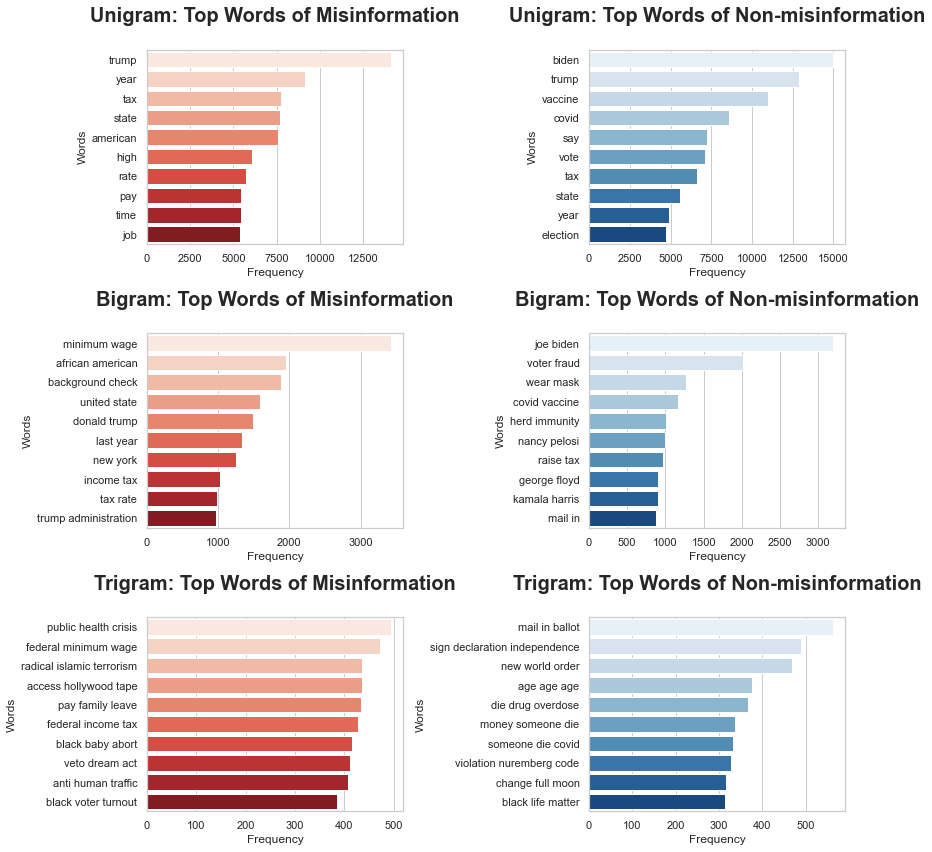

In [4]:
"""
Function to lemmatize a tokenized row of dataframe.
This function incorperates Part of Speech (POS) tags to further lemmatize words.
"""
def lemmatize_row_pos(row, lemmatizer):

    #Set up a dictionary to find relevant lemmatize part of speech (POS)
    lemma_tag = {'N': wordnet.NOUN, 'J': wordnet.ADJ,'V': wordnet.VERB, 'R': wordnet.ADV}
    
    lemmatized_words = []
    
    for word, tag in row:
        partOfSpeech = wordnet.NOUN #set default POS
        tag_key = tag[0] #Find dictionary key, which is first letter of tag
        if tag_key in lemma_tag.keys(): #if word is a lemmatize tag, update accordingly.
            partOfSpeech = lemma_tag[tag_key]
        lemmatized_words.append(lemmatizer.lemmatize(word, pos=partOfSpeech))
    return lemmatized_words


"""
Text preparation for "news_headline"
"""
# 1. Tokenization¶
df_news_1 = df_cleaned['news_headline'].apply(word_tokenize)  #tokenised version
df_news_text = df_cleaned['news_headline'] #normal sentence

# 2. Lower Casing
df_news_2 = df_news_1.apply(lambda x: [word.lower() for word in x])

# 3. Stopwords Removal
## extend stop_words to better know the topic
My_stop_words_nh = stopwords.words("English")
My_stop_words_nh.extend(["n't", "'s", "'m", "'d", "'re", "'ve", "'ll", "u", "s", "us", " us", "us ", "u s",
                         "say", "says", "last", "year", "photo", "show", "shows", "joe", "biden", "donald", "trump",
                         "photo show", "year", "ago", "check", "know", "people", "one", "world"])

df_news_3 = df_news_2.apply(lambda x: [word for word in x if word not in My_stop_words_nh])

# 4. Regular Expression
## Remove characters that are not a letter or spaces. That is, it can remove the number of tweets.
df_news_4 = df_news_3.apply(lambda tokens: [re.sub(r"[^a-zA-Z\s]", " ", token) for token in tokens])

# 5. Lemmatization with POS tags -> avoid every words be identified as "noun"
My_lemmatizer_nh = WordNetLemmatizer() 
df_news_5_POS = df_news_4.apply(lambda x: pos_tag(x))
df_news_6_POS = df_news_5_POS.apply(lambda x: lemmatize_row_pos(x, My_lemmatizer_nh))

# new clean text of "news_headline"
df_news_7_POS = df_news_6_POS.apply(lambda x:" ".join(x))

# add "processed_news" into df_enriched
df_enriched = df_cleaned.copy() # ensure the data integrity
df_enriched["processed_news"] = df_news_7_POS

"""
Text preparation for "related_tweet"
"""
# 1. Tokenization¶
df_tweet_1 = df_cleaned["tweet_content"].apply(word_tokenize)  # tokenised version
df_tweet_text = df_cleaned["tweet_content"] # normal sentence

# 2. Lower Casing
df_tweet_2 = df_tweet_1.apply(lambda x: [word.lower() for word in x])

# 3. Stopwords Removal
# extend stop words: html tag and abbreviaiton
My_stop_words_rt = stopwords.words("English")
My_stop_words_rt.extend(["u", "&amp", "amp", "\n", "&gt;", "&lt;", "gt", "lt", " lt", "n", " n", "thats",
                         "'s", " 's", "'m", "'d", "'re", "'ve", "'ll", "ca ", " ca", "ca not", "get",
                         "say", "go", "one", "like", "know", "think", "people", "need", "would", "also", "even",
                         "want", "make"])

df_tweet_3 = df_tweet_2.apply(lambda x: [word for word in x if word not in My_stop_words_rt])

# 4. Regular Expression 
# replace all things that is not a letter(e.g., number)
df_tweet_4 = df_tweet_3.apply(lambda tokens: [re.sub(r"[^a-zA-Z\s]", " ", token) for token in tokens])

# 5. Lemmatization with POS tags
My_lemmatizer_rt = WordNetLemmatizer() 
df_tweet_5_POS = df_tweet_4.apply(lambda x: pos_tag(x))
df_tweet_6_POS = df_tweet_5_POS.apply(lambda x: lemmatize_row_pos(x, My_lemmatizer_rt))

# new cleaned text of "related_tweet"
df_tweet_7_POS = df_tweet_6_POS.apply(lambda x:" ".join(x))

# add "processed_tweets" into "df_enriched"
df_enriched["processed_tweets"] = df_tweet_7_POS

"""
Visualise "related_tweet" with unigram, bigram & trigram
"""
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g), max_df=0.95).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Filter the corpus based on the value of the "misinformation" column
misinformation_1_corpus = df_enriched[df_enriched['misinformation'] == 1]['processed_tweets']
misinformation_0_corpus = df_enriched[df_enriched['misinformation'] == 0]['processed_tweets']

# Unigram
# misinformation == 1
plt.figure(figsize=(12, 12))
plt.subplot(3, 2, 1)  # Subplot 1
most_common_uni_1 = get_top_text_ngrams(misinformation_1_corpus, 10, 1)
most_common_uni_1 = dict(most_common_uni_1)
sns.barplot(x=list(most_common_uni_1.values()), y=list(most_common_uni_1.keys()), palette="Reds")
plt.title("Unigram: Top Words of Misinformation\n", size=20, fontweight="bold")
plt.xlabel("Frequency")
plt.ylabel("Words")

# misinformation == 0
plt.subplot(3, 2, 2)  # Subplot 2
most_common_uni_0 = get_top_text_ngrams(misinformation_0_corpus, 10, 1)
most_common_uni_0 = dict(most_common_uni_0)
sns.barplot(x=list(most_common_uni_0.values()), y=list(most_common_uni_0.keys()), palette="Blues")
plt.title("Unigram: Top Words of Non-misinformation\n", size=20, fontweight="bold")
plt.xlabel("Frequency")
plt.ylabel("Words")

# Bigram
## misinformation == 1
plt.subplot(3, 2, 3)  # Subplot 3
most_common_bi_1 = get_top_text_ngrams(misinformation_1_corpus, 10, 2)
most_common_bi_1 = dict(most_common_bi_1)
sns.barplot(x=list(most_common_bi_1.values()),y=list(most_common_bi_1.keys()), palette="Reds")
plt.title("Bigram: Top Words of Misinformation\n", size=20, fontweight="bold")
plt.xlabel("Frequency")
plt.ylabel("Words")

# misinformation == 0
plt.subplot(3, 2, 4)  # Subplot 4
most_common_bi_0 = get_top_text_ngrams(misinformation_0_corpus, 10, 2)
most_common_bi_0 = dict(most_common_bi_0)
sns.barplot(x=list(most_common_bi_0.values()),y=list(most_common_bi_0.keys()), palette="Blues")
plt.title("Bigram: Top Words of Non-misinformation\n", size=20, fontweight="bold")
plt.xlabel("Frequency")
plt.ylabel("Words")

# Trigram
## misinformation == 1
plt.subplot(3, 2, 5)  # Subplot 5
most_common_bi_1 = get_top_text_ngrams(misinformation_1_corpus, 10, 3)
most_common_bi_1 = dict(most_common_bi_1)
sns.barplot(x=list(most_common_bi_1.values()),y=list(most_common_bi_1.keys()), palette="Reds")
plt.title("Trigram: Top Words of Misinformation\n", size=20, fontweight="bold")
plt.xlabel("Frequency")
plt.ylabel("Words")

## misinformation == 0
plt.subplot(3, 2, 6)  # Subplot 6
most_common_bi_0 = get_top_text_ngrams(misinformation_0_corpus, 10, 3)
most_common_bi_0 = dict(most_common_bi_0)
sns.barplot(x=list(most_common_bi_0.values()),y=list(most_common_bi_0.keys()), palette="Blues")
plt.title("Trigram: Top Words of Non-misinformation\n", size=20, fontweight="bold")
plt.xlabel("Frequency")
plt.ylabel("Words")

plt.tight_layout() # Adjust layout
plt.show()

# Feature engineering

- New_Feature 1: "tweet_length"
According to my research, the length of a tweet is a kind of content feature that could impact misinformation classification.    


- New_Feature 2: "hashtag_count"
Some hashtags frequently be used based on data exploration, and misinformation might use hashtags to gain attention.    


- New_Feature 3: "avg_favourites_per_tweet" 
Average favourites per tweet can determine the user’s social influence.  


- Feature 4: SVD 
According to the figure "Explained Variance," the best component number is about "2.5". Therefore, I decided to create an array of 3 columns "SVD" to reduce the dimension of "processed_tweets."  


- Feature 5: Doc2Vec
This feature can capture the semantic meaning of each tweet.  


- Feature 6: Topic Modelling
Utilising “processed_news” determines 4 topics based on the highest coherence score. Topics including community issues, health issues, US Policy, and election.

- Feature 7: Sentiment Analysis
Add this feature to know the sentiment of each tweet, the classification criteria are based on +-0.05.

##### Feature 1: tweet_length
The length of "tweet_content."

In [5]:
df_enriched["tweet_length"] = df_enriched["tweet_content"].apply(lambda x: len(x) if isinstance(x, str) else 0)

##### Feature 2: hashtag_count
The number of hashtags in each tweets.

In [6]:
# create a function count the number of hashtags
def count_hashtags(hashtag):
    if hashtag is None:
        return 0
    else:
        return len(hashtag.split("#")) - 1

# new feature "hashtag_count"
df_enriched["hashtag_count"] = df_enriched["hashtags"].apply(count_hashtags)

##### Feature 3: avg_favourites_per_tweet 
avg_favourites_per_tweet = user_favourites / user_tweets_count

In [7]:
df_enriched['avg_favourites_per_tweet'] = df_enriched['user_favourites'] / df_enriched['user_tweets_count']

##### Feature 4: SVD_dimensionality reduction

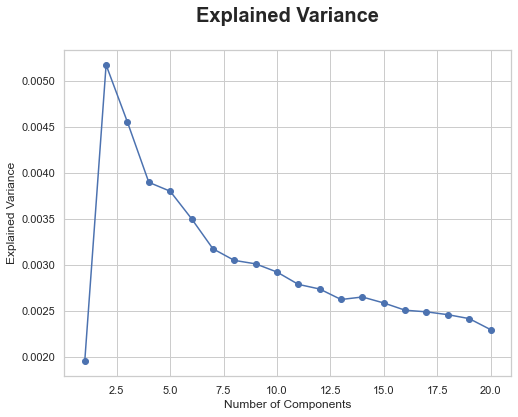

In [8]:
# BOW
df_bow = [' '.join(i) for i in df_tweet_6_POS]
## ignore terms (words) that have a document frequency higher than 95%.
count_vectorizer = CountVectorizer(max_df=0.95)
bag_of_words = count_vectorizer.fit_transform(df_bow)

# TF-IDF_supervised
## Normalize TF-IDF matrix using L2 norm
TFIDF_transformer = TfidfTransformer(norm="l2")
TFIDF_representation = TFIDF_transformer.fit_transform(bag_of_words)

# Dimensionality reduction
## explained variance ratio
My_SVD = TruncatedSVD(n_components=20, n_iter=100)
My_SVD = My_SVD.fit(TFIDF_representation)
explained_variance_ = My_SVD.explained_variance_
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_) + 1), explained_variance_, marker='o', linestyle='-')
plt.title("Explained Variance\n", size=20, fontweight="bold")
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance")
plt.grid(True)
plt.show() # the best component number is about "2.5" -> I decided to created an array of 3 columns

# using SVD based on TF-IDF representation
My_SVD = TruncatedSVD(n_components=3, n_iter=25)
SVD_Note = My_SVD.fit_transform(TFIDF_representation)

# add 3 dimensions to "df_enriched"
# SVD is according to the "processed_tweets"
df_enriched[["SVD1","SVD2", "SVD3"]] = SVD_Note

##### Feature 5: Doc2Vec

In [9]:
# Tokenize and tag documents
tagged_documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df_tweet_7_POS)]

# Train a Doc2Vec model
number_of_vectors = 5
model = Doc2Vec(tagged_documents, vector_size=number_of_vectors, window=10, min_count=1)

#Extract vectors array
model_vectors = model.dv.vectors

#add to dataframe
vector_column_names = ['VEC'+str(i+1) for i in range(number_of_vectors)]
df_enriched[vector_column_names] = model_vectors

##### Feature 6: Topic Modeling

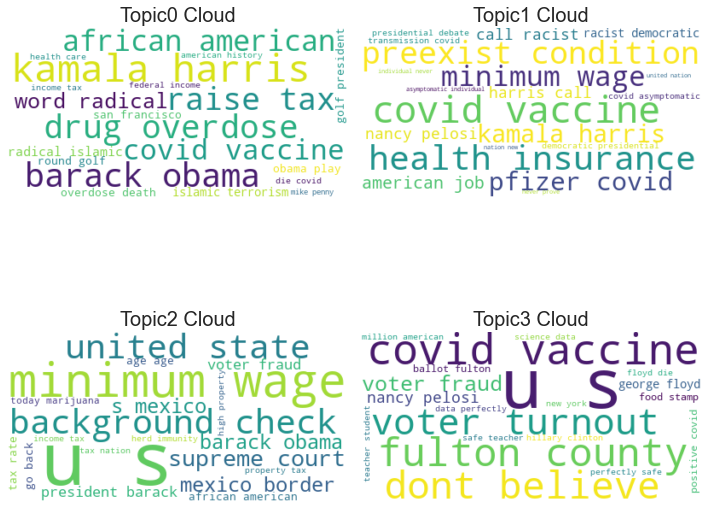

In [10]:
# Categorised each row by the topic of "processed_news" (original "news_headline")
# LDA (Unsupervised, tokenize words)
My_id2word = corpora.Dictionary(df_news_6_POS)

# Converting document (a list of words) into the BOW[Bag of words] format
My_Corpus = [My_id2word.doc2bow(text) for text in df_news_6_POS]

# Choose the number of topic based on the coherence score 
cv_score_list = []
for i in range(2,8):
    My_LDA = models.LdaMulticore(corpus=My_Corpus, id2word=My_id2word,
                             num_topics=i, random_state=0)
    
    cm = CoherenceModel(model=My_LDA, corpus=My_Corpus, texts=df_news_6_POS,
    dictionary=My_id2word, coherence='c_v')
    
    coherence = cm.get_coherence()
    cv_score_list.append({'topics': i, 'score': coherence})

# Build LDA model
# The coherence score of 4 topics is the highest -> choose 4 topics
My_LDA = models.LdaMulticore(corpus=My_Corpus, id2word=My_id2word,
                             num_topics=4, random_state= 0)

# get topic probabilities
topic_probabilities = list(My_LDA.get_document_topics(bow=My_Corpus, minimum_probability=0.00))
probabilities = [[prob for topic, prob in row] for row in topic_probabilities]

# get most probable topic
most_probable = [prob.index(max(prob)) for prob in probabilities]

# Adding probabilities to dataframe
df_enriched[["Topic0", "Topic1", "Topic2", "Topic3"]] = probabilities
df_enriched["probable_topic"] = most_probable

"""
Topic categorisation:
- topic_0: Community Issues
- topic_1: Health Issues
- topic_2: US Policy
- topic_3: Election

"""

topic0_words = ", ".join(df_enriched[df_enriched["probable_topic"] == 0]["processed_news"])
topic1_words = ", ".join(df_enriched[df_enriched["probable_topic"] == 1]["processed_news"])
topic2_words = ", ".join(df_enriched[df_enriched["probable_topic"] == 2]["processed_news"])
topic3_words = ", ".join(df_enriched[df_enriched["probable_topic"] == 3]["processed_news"])

topic_words = [topic0_words, topic1_words, topic2_words, topic3_words]

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize= (10, 10))

# Plot word clouds in each subplot
for i, ax in enumerate(axes.flat):
    wordcloud = WordCloud(max_words=20, background_color="white").generate(topic_words[i]).to_image()
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f'Topic{i} Cloud', size=20) 
    ax.axis('off')

plt.tight_layout()
plt.show()

##### Feature 7: Sentiment Analysis

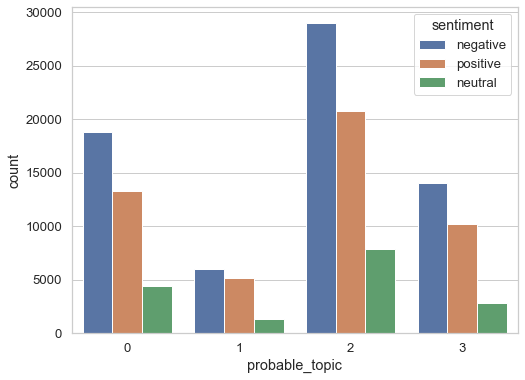

In [11]:
# Lexicon-based method -> because this data is unlabeled dataset -> use "unsupervised" text analysis
My_sentiment_analyser = SentimentIntensityAnalyzer()

sentiment_score = []

# Use the dataframe without token, because cleaned data sometimes can change the "positive" or "negative"
for sentence in df_tweet_text:
    text_score = My_sentiment_analyser.polarity_scores(sentence)['compound']
    sentiment_score.append(text_score)

"""
- Compound score:
+1: extreme positive
>=0.05: positive
>-0.05 and <0.05: neutral
<= -0.05: negative
-1: extreme negative
"""
sentiment_list = []
for score in sentiment_score:
    if score >= 0.05:
        sentiment_list.append("positive")
    elif score <= -0.05:
        sentiment_list.append("negative")
    else:
        sentiment_list.append("neutral")
        
df_enriched["sentiment_score"] = sentiment_score
df_enriched["sentiment"] = sentiment_list

# Visualisation with topic
plt.figure(figsize = (8,6))
sns.set(style = "whitegrid", font_scale = 1.2)
chart = sns.countplot(x = "probable_topic", hue = "sentiment" , data = df_enriched)
chart.set_xticklabels(chart.get_xticklabels())
plt.show()

# Model building & evaluation

1. **Data**
- Columns won't be used in model building:
    - "user_favourites" and "user_tweets_count": Because it was combined with the new feature "avg_favourites_per_tweet."
    - "post_favourites" "user_tweet_count_lists": Because they are highly correlated with other columns.
    - "news_headline", "related_tweet", "mentions", "tweet_content", "hashtags", "processed_news", "processed_tweets", "probable_topic", and "sentiment": Because they are categorical data or text.  
    
    - **User feature**: focus on user attributes, behaviours, and social networking.  
        - "user_followers", "user_friends", "avg_favourites_per_tweet"
    - **Content feature**: focus on the tweet's content.  
        - "news_author", "post_replies", "post_retweets", "user_mentions", "tweet_length", "hashtag_count", "SVD1", "SVD2", "SVD3", "VEC1", "VEC2", "VEC3", "VEC4", "VEC5", "Topic0", "Topic1", "Topic2", "Topic3","sentiment_score"
    
2. **Model: Neural Network_MLPClassifier**
- This is labelled data, but we do not have too much knowledge of the relationships between misinformation and other features. Neural Network is suitable for this kind of data.
- MLPClassifier can learn non-linear models.
- This model is suitable for real-world data and our dataset is from X(Twitter).

3. **Evaluation method & metrics**  
- Use "cross-validation" to evaluate our model.
- Consider five metrics, including accuracy, F1-score, recall, precision, and roc_auc.
    - The performance of this model is good because the ROC = 0.9.
    - To determine misinformation, I think "recall" is the most important metric. Because I want to capture as much as possible misinformation tweets so that people can avoid being misled. It is acceptable that recall = 0.85 in this model.
    - The F1 score is worth understanding because it integrates precision and recall so that can balance each's performance. F1 = 0.85 means this model performs well in these two indicators.

4. **Consideration**
- MLPClassifier has a potential issue in that it has a hidden layer so it might have an overfitting problem if the parameter was not well set. 
- Our model did not have too many user features. To better classify misinformation data, more user features can be collected in the future.

      Metric     Score
0   Accuracy  0.843636
1         F1  0.851576
2     Recall  0.852892
3  Precision  0.845396
4    ROC AUC  0.907742


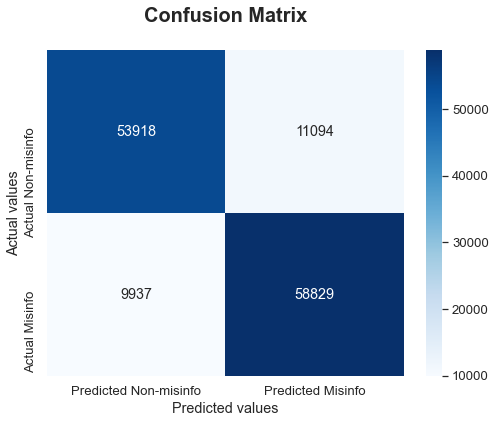

In [13]:
# neural network
MLP_clf = MLPClassifier(hidden_layer_sizes=(25,), max_iter=200)

# Standardizing the data
My_StandardScaler = StandardScaler()
X_features = df_enriched.drop(columns=['news_headline', 'related_tweet', 'user_favourites', 'post_favourites',
                                     'user_tweets_count', 'user_tweet_count_lists',
                                     'misinformation', 'mentions', 'tweet_content','hashtags', 'processed_news', 
                                     'processed_tweets', 'probable_topic', 'sentiment'])
X = My_StandardScaler.fit_transform(X_features)
y = df_enriched["misinformation"]

# model evaluation
score_list = ["Accuracy", "F1", "Recall", "Precision", "ROC AUC"]
score_metric = ["accuracy", "f1", "recall", "precision", "roc_auc"]

score_data = []
for i in range(len(score_list)):
    s_list = score_list[i]
    s_metric = score_metric[i]
    score_mean = cross_val_score(MLP_clf , X, y, cv=5, scoring=s_metric).mean()
    score_data.append([s_list, score_mean])

df_scores = pd.DataFrame(score_data, columns=['Metric', 'Score'])
print(df_scores)

# Confusion Matrix
y_MLP_clf_predicted_CV = cross_val_predict(MLP_clf, X, y, cv = 5)
CM_CV = confusion_matrix(y, y_MLP_clf_predicted_CV)

# Visualise the Confusion Matrix (CM_CV)
plt.figure(figsize=(8,6))
sns.heatmap(CM_CV, annot=True, cmap="Blues", fmt="g", xticklabels=["Predicted Non-misinfo", "Predicted Misinfo"],
               yticklabels=["Actual Non-misinfo", "Actual Misinfo"])
plt.xlabel("Predicted values")
plt.ylabel("Actual values")
plt.title("Confusion Matrix\n", size=20, fontweight="bold")
plt.show()